# Data_Cleaning, Data_Engineering, Data_Visualizations

## VIX Group

### 1. Load Data & Define Skeleton

**Explanation:** Standard loading procedure. We define the VIX path and load the surgical skeleton.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
# We use the surgically imputed file to ensure dates are perfect
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load Raw VIX Data
vix_path = os.path.join(raw_dir, "vix_daily.csv")
df_vix_raw = pd.read_csv(vix_path)
df_vix_raw['date'] = pd.to_datetime(df_vix_raw['date'])
df_vix_raw = df_vix_raw.rename(columns={'vix_index': 'VIX_Close'})

print(f"Skeleton Dates: {len(unique_dates)}")
print(f"Raw VIX Rows: {len(df_vix_raw)}")
df_vix_raw.head()

Skeleton Dates: 3443
Raw VIX Rows: 4079


,date,VIX_Close
0,2010-01-04,20.04
1,2010-01-05,19.35
2,2010-01-06,19.16
3,2010-01-07,19.06
4,2010-01-08,18.13


### 2. Merge & Impute

**Explanation:** Left Join onto the Skeleton.

**Note on Imputation:** VIX follows the US Stock Market schedule almost perfectly. Gaps should be minimal compared to Oil/Gas. We still ffill just in case of weird data gaps.

In [8]:
# 1. Merge (Left Join)
df_vix_clean = pd.merge(unique_dates, df_vix_raw, on='date', how='left')

# 2. Impute (Forward Fill)
df_vix_clean['VIX_Close'] = df_vix_clean['VIX_Close'].ffill()
df_vix_clean['VIX_Close'] = df_vix_clean['VIX_Close'].bfill()

print(f"Merged VIX Shape: {df_vix_clean.shape}")
print(f"Missing Values: {df_vix_clean['VIX_Close'].isna().sum()}")

Merged VIX Shape: (3443, 2)
Missing Values: 0


### 3. Feature Engineering (VIX Specific)

**Explanation:** We calculate Log Returns (standard) and Daily Difference (unique importance for VIX). We also create a "Fear Regime" indicator (VIX > 50-Day MA).

In [11]:
# Helper Function for RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Log Returns (Percentage Change in Fear)
df_vix_clean['VIX_Log_Return'] = np.log(df_vix_clean['VIX_Close'] / df_vix_clean['VIX_Close'].shift(1))

# 2. Simple Difference (Absolute Change in Points)
# e.g., +5.0 means VIX spiked 5 points today
df_vix_clean['VIX_Diff'] = df_vix_clean['VIX_Close'].diff()

# 3. RSI (14-Day)
# RSI > 70 on VIX usually marks "Peak Fear" (Market Bottom)
df_vix_clean['VIX_RSI'] = calculate_rsi(df_vix_clean['VIX_Close'])

# 4. Moving Averages (Regime Detection)
df_vix_clean['VIX_MA50'] = df_vix_clean['VIX_Close'].rolling(window=50).mean()

# 5. Regime Feature (Is Fear Rising?)
# Ratio > 1.0 means Current Fear is higher than average (Bear Market signal)
df_vix_clean['VIX_to_MA50'] = df_vix_clean['VIX_Close'] / df_vix_clean['VIX_MA50']

print("VIX Feature Engineering Complete.")
df_vix_clean.tail()

VIX Feature Engineering Complete.


,date,VIX_Close,VIX_Log_Return,VIX_Diff,VIX_RSI,VIX_MA50,VIX_to_MA50
3438,2023-12-21,13.65,-0.001464,-0.02,61.283186,15.1884,0.898712
3439,2023-12-22,13.03,-0.046485,-0.62,49.466951,15.1152,0.862046
3440,2023-12-26,12.99,-0.003075,-0.04,51.555556,14.9886,0.866659
3441,2023-12-27,12.43,-0.044067,-0.56,44.534413,14.8930,0.834620
3442,2023-12-28,12.47,0.003213,0.04,43.967280,14.7848,0.843434


### 4. Save VIX Dataset

**Explanation:** Saving as VIX_engineered_5.csv.

In [14]:
output_path = os.path.join(semi_clean_dir, "VIX_engineered_5.csv")
df_vix_clean.to_csv(output_path, index=False)
print(f"Saved processed VIX data to: {output_path}")

Saved processed VIX data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\VIX_engineered_5.csv


### 5. Overlay Visualization (Stock vs. Fear)

**Explanation:** 

   **Expectation:** You should see a Negative Correlation. When the Orange line (VIX) spikes up, the Navy line (Stock) should crash down.

   **Key Event:** Look at March 2020 (Pandemic). VIX hit ~80. Stocks hit lows.

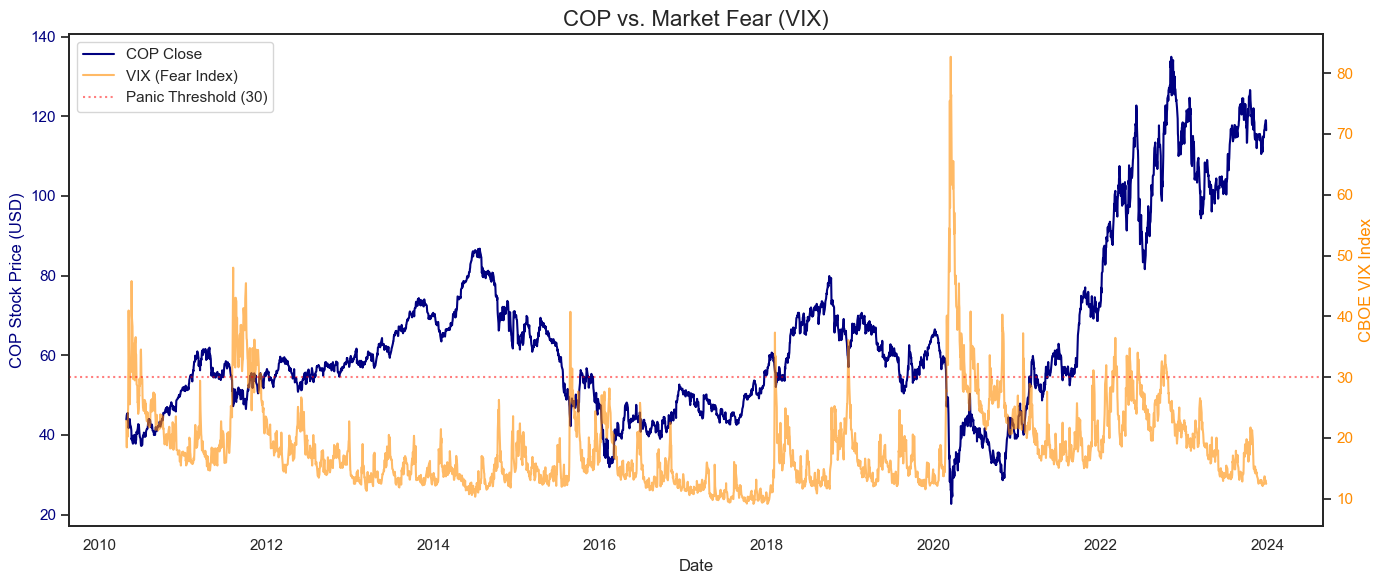

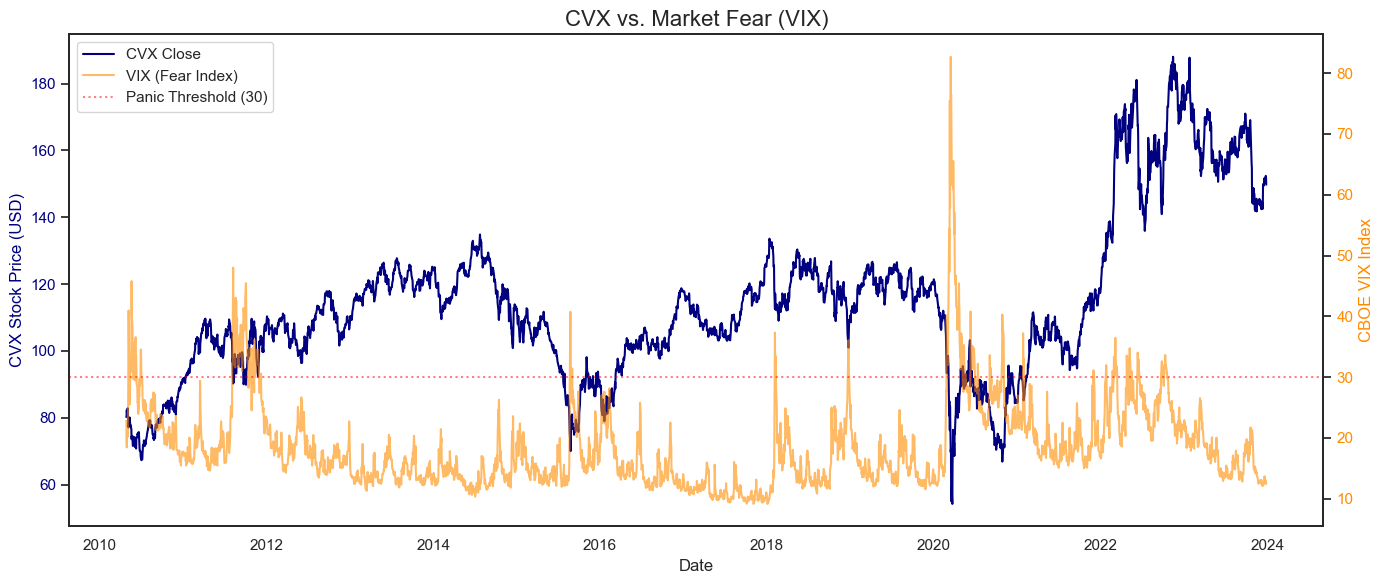

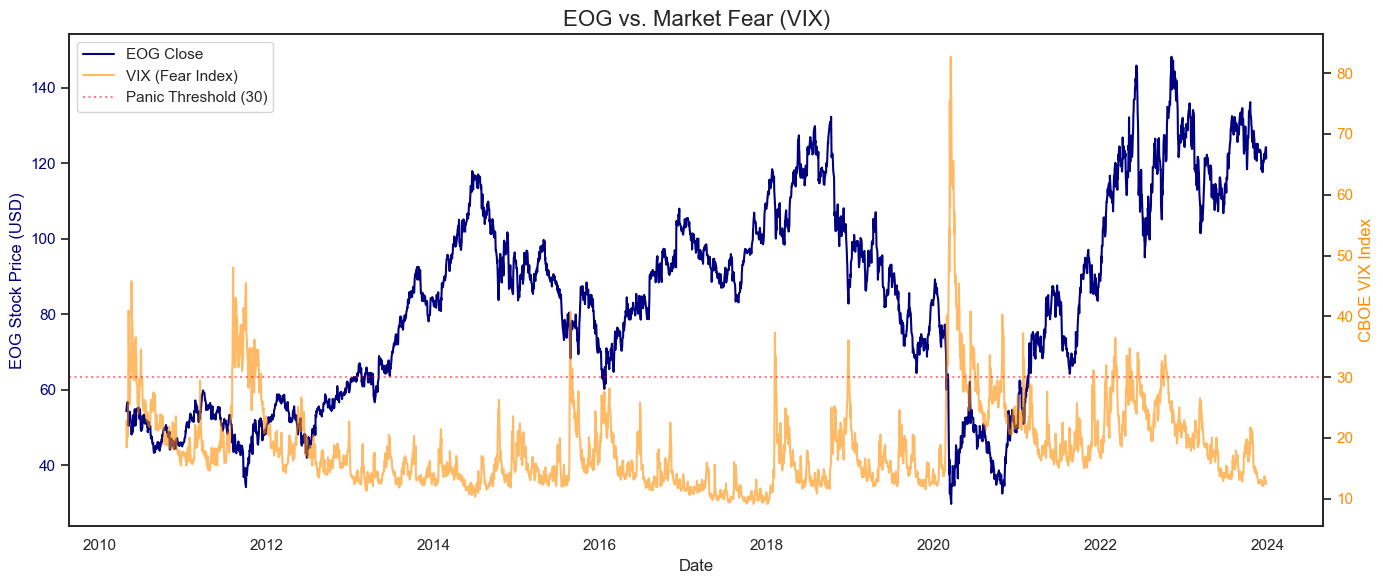

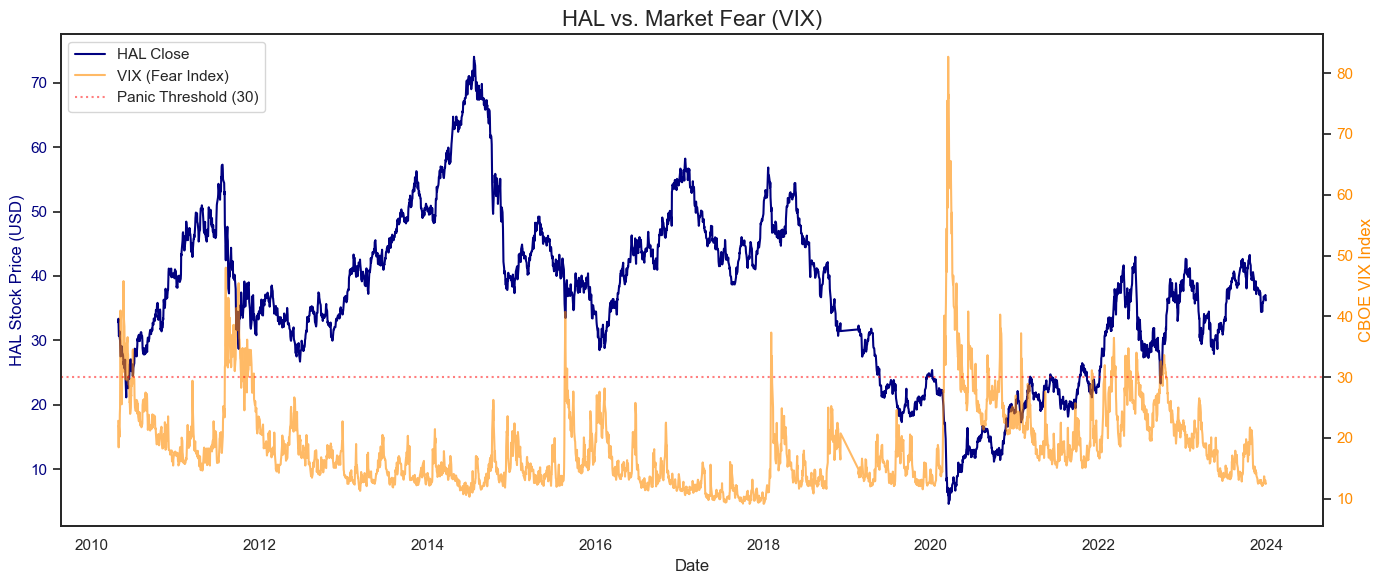

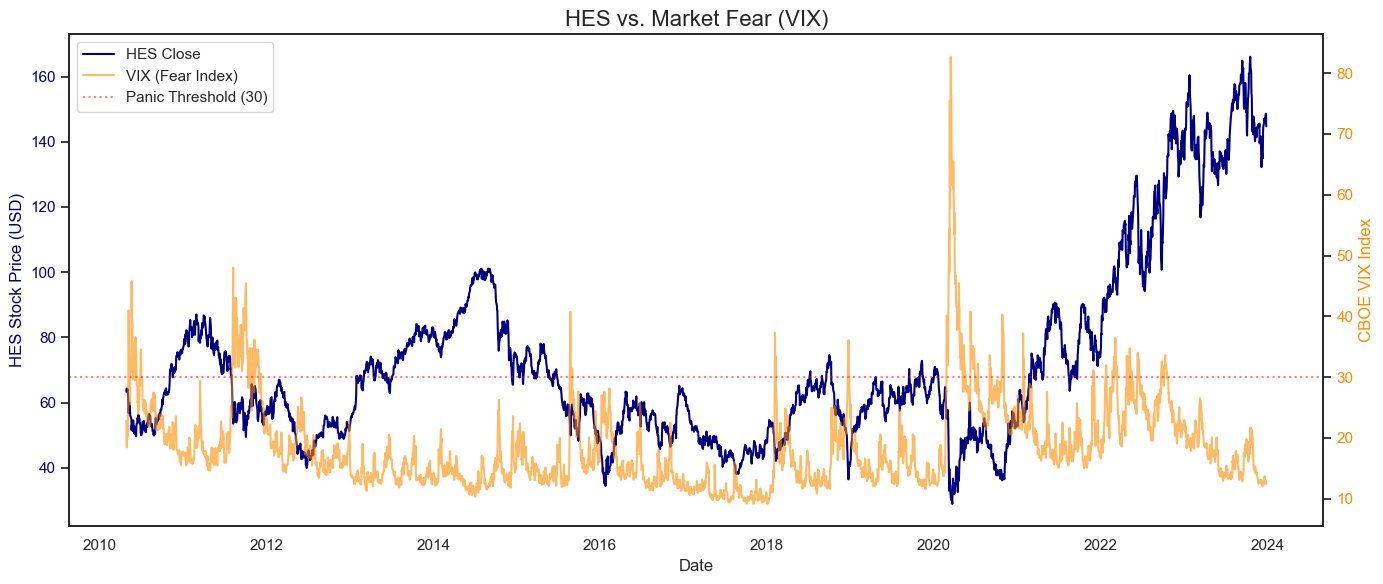

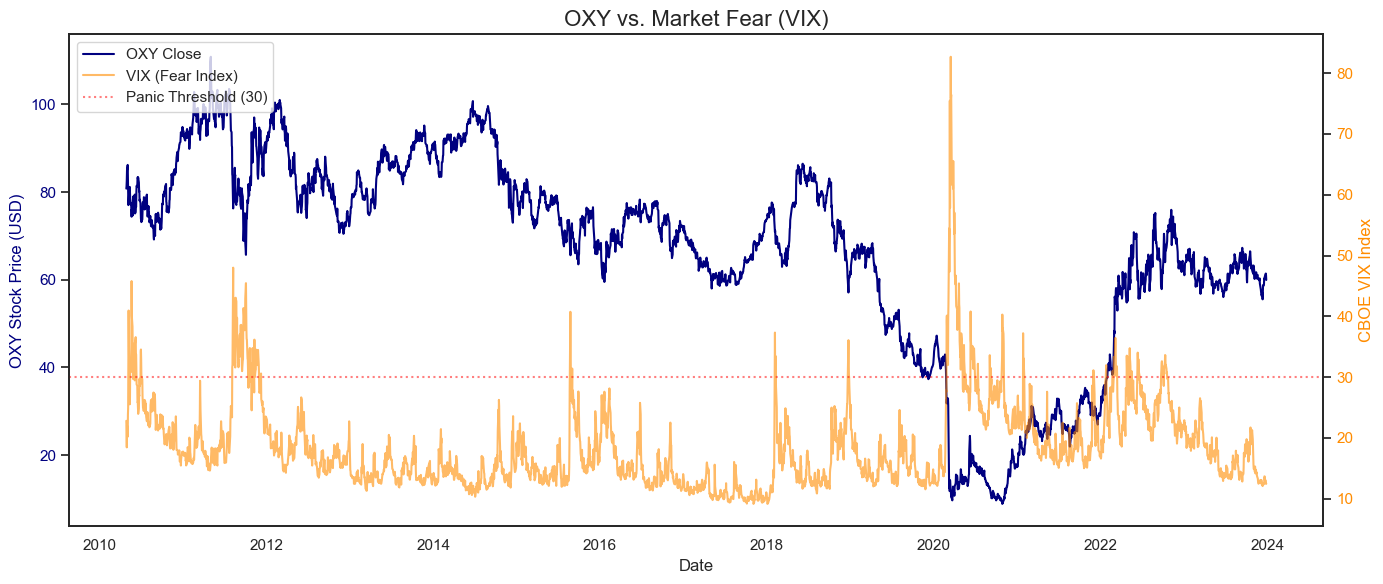

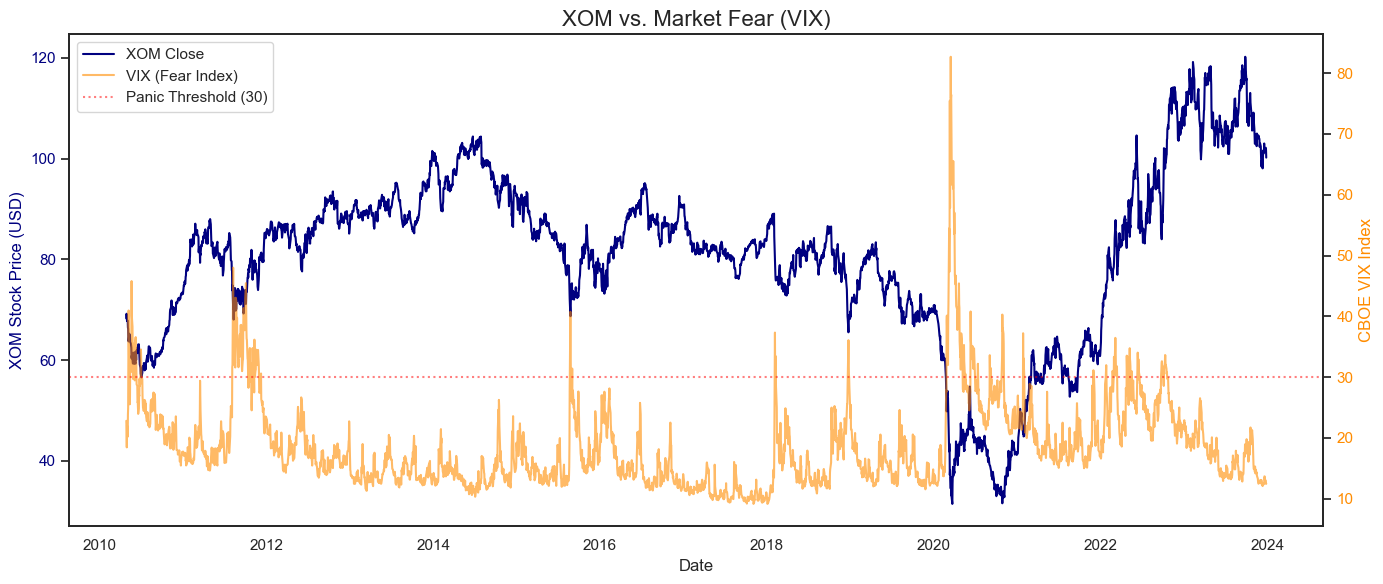

In [17]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_vix_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. VIX (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'darkorange' # Orange is the classic "Warning" color
    ax2.set_ylabel('CBOE VIX Index', color=color2, fontsize=12)
    ax2.plot(subset['date'], subset['VIX_Close'], color=color2, label='VIX (Fear Index)', linestyle='-', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add Threshold line for "Extreme Fear" (VIX=30 is usually the panic threshold)
    ax2.axhline(30, color='red', linestyle=':', alpha=0.5, label='Panic Threshold (30)')

    plt.title(f"{t} vs. Market Fear (VIX)", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()